# Portfolio optimizálás

In [197]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import scipy.optimize as sc

In [116]:
def getData(stocks, start, end):
    stockdata= yf.download(stocks, start=start, end=end, adjusted=True, progress=False)
    stockdata=stockdata['Adj Close']
    
    # Simple returns
    returns         = stockdata.pct_change()
    meanReturns     = returns.mean()
    covMatrix       = returns.cov()
    
    #log returns
    returns_log     = np.log(stockdata/stockdata.shift(1))
    meanReturns_log = returns_log.mean()
    covMatrix_log   = returns_log.cov()

    return meanReturns, covMatrix, meanReturns_log,  covMatrix_log, stockdata

In [117]:
def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)
    return returns, std

In [145]:
assets = ['OTP.BD', 'ZWACK.BD', 'MOL.BD', '4IG.BD']
weights = np.array([1/len(assets)]*len(assets))

In [146]:
endDate= dt.datetime.now()- dt.timedelta(days=1)
startDate = '2021-01-01'

meanReturns, covMatrix, meanReturns_log,  covMatrix_log, stockdata = getData(assets, startDate, endDate)
returns, std = portfolioPerformance(weights, meanReturns, covMatrix)
returns_log, std_log = portfolioPerformance(weights, meanReturns_log, covMatrix_log)

print('Átlagos (várható) hozam az időszakban')
print(meanReturns)
print('\nCovarancia mátrix')
print(covMatrix)

print('\nÁtlagos (várható) hozam az időszakban (LOG)')
print(meanReturns_log)
print('\nCovarancia mátrix (LOG)')
print(covMatrix_log)

print('\nÉvesített portfolio hozam:{:.2%} (log{:.2%})\
    \nkockázat/szórás/volatilitás:{:.2%} (log {:.2%})'.format(returns, returns_log,std, std_log))

Átlagos (várható) hozam az időszakban
4IG.BD     -0.000179
MOL.BD     -0.000391
OTP.BD     -0.000677
ZWACK.BD   -0.000053
dtype: float64

Covarancia mátrix
            4IG.BD    MOL.BD    OTP.BD  ZWACK.BD
4IG.BD    0.000092  0.000056  0.000037  0.000007
MOL.BD    0.000056  0.000321  0.000098  0.000002
OTP.BD    0.000037  0.000098  0.000189 -0.000002
ZWACK.BD  0.000007  0.000002 -0.000002  0.000067

Átlagos (várható) hozam az időszakban (LOG)
4IG.BD     -0.000223
MOL.BD     -0.000546
OTP.BD     -0.000769
ZWACK.BD   -0.000085
dtype: float64

Covarancia mátrix (LOG)
            4IG.BD    MOL.BD    OTP.BD  ZWACK.BD
4IG.BD    0.000091  0.000056  0.000036  0.000007
MOL.BD    0.000056  0.000318  0.000098  0.000002
OTP.BD    0.000036  0.000098  0.000189 -0.000001
ZWACK.BD  0.000007  0.000002 -0.000001  0.000066

Évesített hozam:-8.19% (log-10.23%)    
kockázat/szórás/volatilitás:12.95% (log 12.92%)


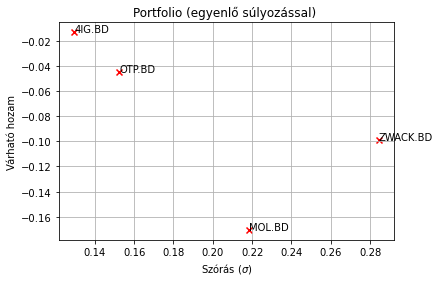

In [187]:
sigma = stockdata.pct_change().std()* np.sqrt(252)
mu = stockdata.pct_change().mean()*252
n = assets

fig, ax = plt.subplots()
ax.scatter(x=sigma, y=mu, marker='x', color='red')

for i, txt in enumerate(n):
    ax.annotate(txt, (sigma[i]+0.0002, mu[i]))
    ax.grid(True)
    
plt.title("Portfolio (egyenlő súlyozással) ")
plt.xlabel("Szórás ($\sigma$)")
cx=plt.ylabel("Várható hozam")

In [188]:
sigma

4IG.BD      0.152393
MOL.BD      0.284301
OTP.BD      0.218379
ZWACK.BD    0.129488
dtype: float64

In [189]:
mu

4IG.BD     -0.045069
MOL.BD     -0.098614
OTP.BD     -0.170530
ZWACK.BD   -0.013247
dtype: float64

In [190]:
np.dot(sigma, mu)

-0.07385975323018366

In [193]:
(0.152393*-0.045069) + (0.284301*-0.098614)+(0.218379*-0.170530) + (0.129488*-0.013247)

-0.073859757337

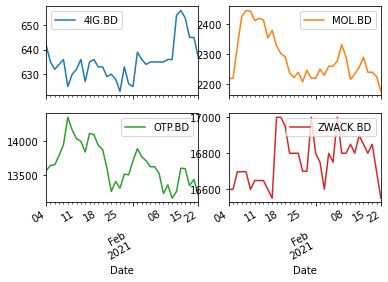

In [136]:
ax = stockdata.plot(subplots=True, layout=(2,2))

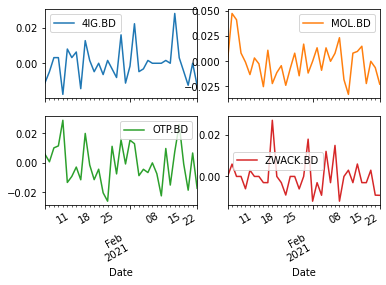

In [133]:
ax=np.log(stockdata/stockdata.shift(1)).dropna().plot(subplots=True, layout=(2,2))

In [147]:
# optimalizálás
weights = np.array([1/len(assets)]*len(assets))
weights

array([0.25, 0.25, 0.25, 0.25])

In [195]:
def negativeSR(weights, meanReturns, covMatrix, riskFree=0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return -(pReturns -riskFree)/pStd

In [196]:
def maxSR(meanReturns, covMatrix, riskFree=0, constrainSet=(0,1)):
    'minimize the negative sharp ratio by altering the weights of the portfolio'
    numAssets = len(meanReturns)
    args=(meanReturns, covMatrix, riskFree)
    constraints=(
        {'type':'eq',
        'fun': lambda x:np.sum(x)-1})

    bound = constrainSet
    bounds = tuple(bound for assets in range(numAssets))

    result=sc.minimize(negativeSR, 
        numAssets*[1./numAssets], 
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints)

    return result

In [198]:
result = maxSR(meanReturns, covMatrix)
result

     fun: 0.34686464548878465
     jac: array([9.75655541e-02, 3.72529030e-09, 4.94220220e-01, 4.48278897e-02])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([8.50708393e-15, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [199]:
def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]

def minimizeVariance(meanReturns, covMatrix, riskFree=0, constrainSet=(0,1)):
    numAssets = len(meanReturns)
    args=(meanReturns, covMatrix )
    constraints=(
        {'type':'eq',
        'fun': lambda x:np.sum(x)-1})

    bound = constrainSet
    bounds = tuple(bound for assets in range(numAssets))

    result=sc.minimize(portfolioVariance, 
        numAssets*[1./numAssets], 
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints)

    return result

minVarResult = minimizeVariance(meanReturns, covMatrix)
minVar, minVarWeights = minVarResult['fun'], minVarResult['x']
print('\n Min Variance')
print(minVar, minVarWeights )


 Min Variance
0.09786261316928947 [0.30150489 0.02106471 0.13633498 0.54109543]


In [202]:
def calculatedResults(meanReturns, covMatrix, riskFree=0, constrainSet=(0,1)):
    # max sharpe ratio
    maxSR_portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_portfolio['x'], meanReturns, covMatrix)
    maxSR_allocation= pd.DataFrame(maxSR_portfolio['x'], index=meanReturns.index, columns=['allocation'])

    # min volatility portfolio
    minVol_portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_portfolio['x'], meanReturns, covMatrix)
    minVol_allocation= pd.DataFrame(minVol_portfolio['x'], index=meanReturns.index, columns=['allocation'])

    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation

In [205]:
maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation = calculatedResults(meanReturns, covMatrix)
print('Max Sharpe Ratio portfolio')
print('Returns:\t{:.2%} \nVolatility:\t{:.2%} \nWeights:{}'.format(maxSR_returns, maxSR_std, maxSR_allocation.round(6)))
print('\n')
print('Min Volatility portfolio')
print('Returns:\t{:.2%} \nVolatility:\t{:.2%} \nWeights:{}'.format(minVol_returns, minVol_std, minVol_allocation.round(6)))

Max Sharpe Ratio portfolio
Returns:	-9.86% 
Volatility:	28.43% 
Weights:          allocation
4IG.BD           0.0
MOL.BD           1.0
OTP.BD           0.0
ZWACK.BD         0.0


Min Volatility portfolio
Returns:	-4.61% 
Volatility:	9.79% 
Weights:          allocation
4IG.BD      0.301505
MOL.BD      0.021065
OTP.BD      0.136335
ZWACK.BD    0.541095


In [206]:
def portfolioReturns(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]

# Efficient frontier
def efficientOpt(meanReturns, covMatrix, returnTarget, constrainSet=(0,1)):
    numAssets = len(meanReturns)
    args=(meanReturns, covMatrix)
    
    constraints=({'type':'eq','fun': lambda x: portfolioReturns(x, meanReturns, covMatrix)-returnTarget},
                 {'type':'eq','fun': lambda x: np.sum(x)-1})

    bound=constrainSet
    bounds = tuple(bound for asset in range(numAssets)) 

    effOpt = sc.minimize(portfolioVariance, numAssets*[1/numAssets], 
        args=args, 
        constraints = constraints, 
        bounds= bounds, 
        method= 'SLSQP')

    return effOpt


In [207]:
efficientOpt(meanReturns, covMatrix, 0.1)

     fun: 0.12948802623411446
     jac: array([ 0.0144702 ,  0.00317851, -0.0034661 ,  0.12948803])
 message: 'Positive directional derivative for linesearch'
    nfev: 415
     nit: 33
    njev: 29
  status: 8
 success: False
       x: array([7.41613137e-13, 6.85913508e-13, 1.75639913e-16, 1.00000000e+00])